              precision    recall  f1-score      support
0              0.830165  0.864116  0.846800   758.000000
1              0.514151  0.448560  0.479121   243.000000
accuracy       0.763237  0.763237  0.763237     0.763237
macro avg      0.672158  0.656338  0.662961  1001.000000
weighted avg   0.753450  0.763237  0.757543  1001.000000


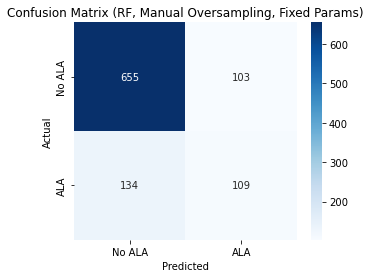

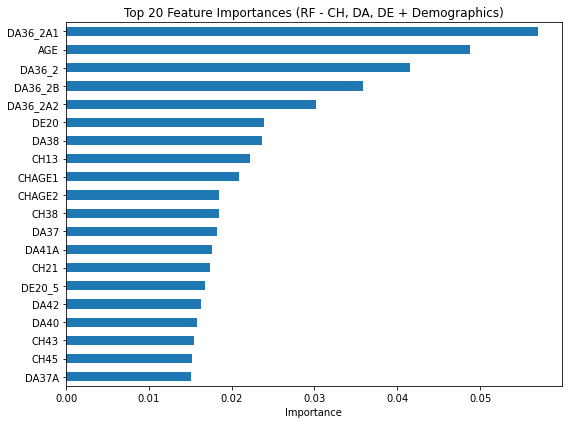

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


# Reload data
df = pd.read_csv("35067-0001-Data.tsv", sep='\t')
df = df[df["DSM_ALA"].isin([1, 5])].copy()
df["DSM_ALA_BINARY"] = df["DSM_ALA"].replace({5: 0, 1: 1})

# Feature selection: CH, DA, DE + demographics
prefixes = ['CH', 'DA', 'DE']
demographic_cols = ['AGE', 'SEX', 'MARITAL', 'EDUC', 'EMPSTAT', 'INCOME']
core_features = [col for col in df.columns if any(col.startswith(p) for p in prefixes)]
available_demos = [col for col in demographic_cols if col in df.columns]
features = core_features + available_demos

X = df[features]
y = df["DSM_ALA_BINARY"]

# Handle missing values
#missing_vals = [-9, -8, -7, -6, -5, -4, -3, -2, -1]
#X = X.applymap(lambda x: np.nan if x in missing_vals else x)
#X = X.dropna(axis=1, how='all')
#imputer = SimpleImputer(strategy="most_frequent")
#X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Manual oversampling
train_data = pd.concat([X_train, y_train], axis=1)
majority = train_data[train_data["DSM_ALA_BINARY"] == 0]
minority = train_data[train_data["DSM_ALA_BINARY"] == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
balanced = pd.concat([majority, minority_upsampled])
X_bal = balanced.drop("DSM_ALA_BINARY", axis=1)
y_bal = balanced["DSM_ALA_BINARY"]

# Train Random Forest (fixed hyperparameters)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_bal, y_bal)

# Evaluate
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
importances = pd.Series(rf.feature_importances_, index=X_bal.columns).sort_values(ascending=False).head(20)

# Show classification report
print(pd.DataFrame(report).T)

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No ALA', 'ALA'], yticklabels=['No ALA', 'ALA'])
plt.title("Confusion Matrix (RF, Manual Oversampling, Fixed Params)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
plt.figure(figsize=(8,6))
importances.plot(kind='barh')
plt.title("Top 20 Feature Importances (RF - CH, DA, DE + Demographics)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
